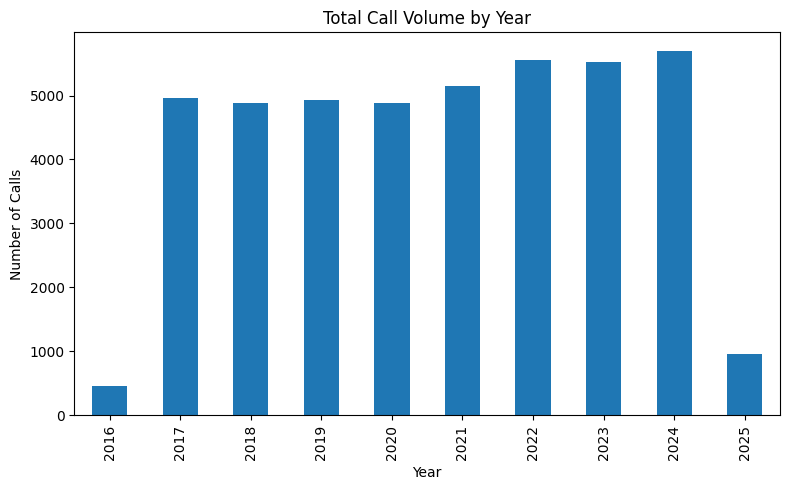

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/clean/calls_by_district_and_time_segment_with_year.csv")


# group by year and count the number of calls
calls_by_year = df.groupby('year').size()

# plot
plt.figure(figsize=(8, 5))
calls_by_year.plot(kind='bar')
plt.title('Total Call Volume by Year')
plt.xlabel('Year')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.show()

/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/3252574578.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  call_counts = df.groupby(['weekday', 'time_segment']).size()
/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/3252574578.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['weekday', 'time_segment']).size()


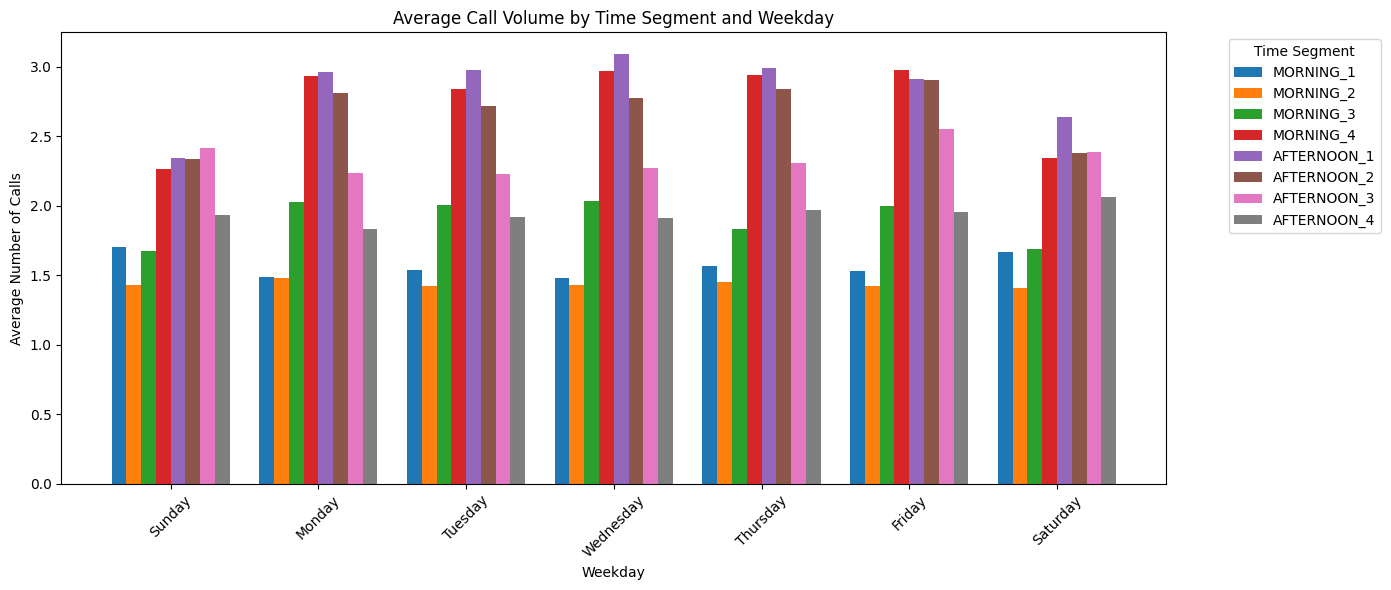

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# define the time segment and weekday order
time_order = ['MORNING_1', 'MORNING_2', 'MORNING_3', 'MORNING_4',
              'AFTERNOON_1', 'AFTERNOON_2', 'AFTERNOON_3', 'AFTERNOON_4']
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# ensure weekday is a categorical column in correct order
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)
df['time_segment'] = pd.Categorical(df['time_segment'], categories=time_order, ordered=True)

# compute average number of calls per (weekday, time_segment)
# count total calls
call_counts = df.groupby(['weekday', 'time_segment']).size()

# count how many unique (weekday, time_segment) appearances exist (i.e., in how many weeks or days)
# assuming each row is a separate call, count how often each combo appears
combo_occurrences = df.drop_duplicates(subset=['year', 'week_of_year', 'weekday', 'time_segment']) \
    .groupby(['weekday', 'time_segment']).size()

# calculate average calls per combo
avg_calls = call_counts / combo_occurrences

# pivot to wide format for plotting
avg_counts = avg_calls.unstack(fill_value=0)

# reindex for full coverage
avg_counts = avg_counts.reindex(index=weekday_order, columns=time_order, fill_value=0)

# plot grouped bar chart
x = np.arange(len(weekday_order))  # base x positions for each weekday
width = 0.1  # width of each bar

plt.figure(figsize=(14, 6))

for i, segment in enumerate(time_order):
    plt.bar(x + i * width, avg_counts[segment], width=width, label=segment)

plt.xticks(x + width * 3.5, weekday_order, rotation=45)
plt.xlabel('Weekday')
plt.ylabel('Average Number of Calls')
plt.title('Average Call Volume by Time Segment and Weekday')
plt.legend(title='Time Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


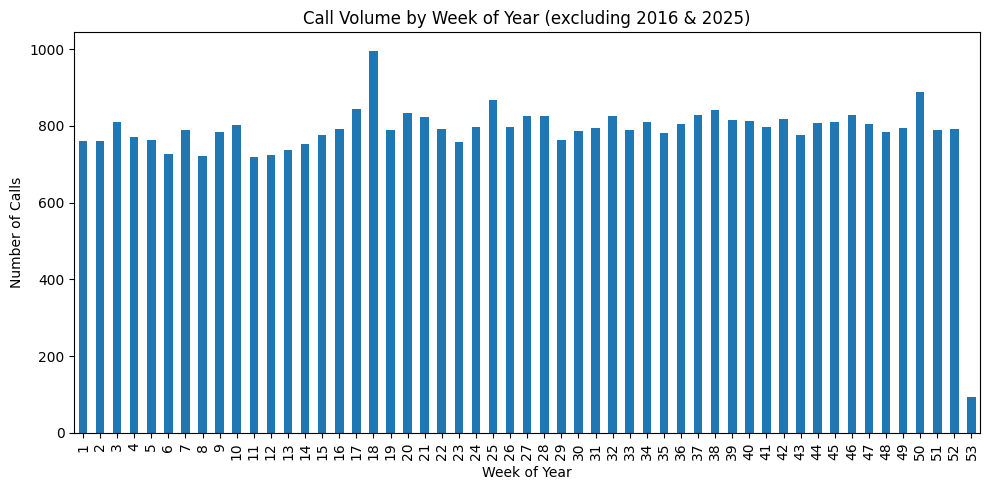

In [5]:
# filter out unwanted years
df_filtered = df[~df['year'].isin([2016, 2025])]

# group by week_of_year
calls_by_week = df_filtered.groupby('week_of_year').size().sort_index()

# plot
plt.figure(figsize=(10, 5))
calls_by_week.plot(kind='bar')
plt.title('Call Volume by Week of Year (excluding 2016 & 2025)')
plt.xlabel('Week of Year')
plt.ylabel('Number of Calls')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/var/folders/0z/d22cxjf5413996fwwtvz8s2c0000gn/T/ipykernel_63986/416745304.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby(['week_of_year', 'weekday']).size()


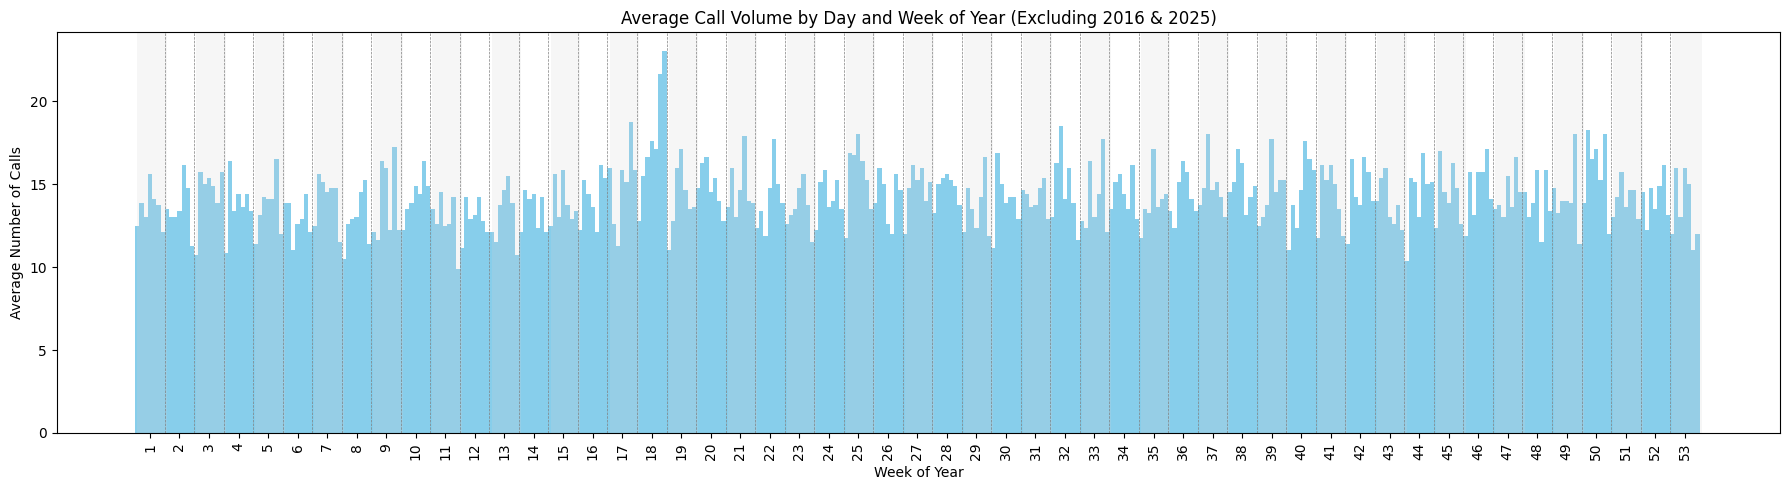

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# filter out 2016 and 2025
df_filtered = df[~df['year'].isin([2016, 2025])]

# enforce consistent weekday order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_filtered['weekday'] = pd.Categorical(df_filtered['weekday'], categories=weekday_order, ordered=True)

# count how many years exist per week_of_year
week_years = df_filtered.groupby(['week_of_year', 'year']).ngroup()
df_filtered['week_year_id'] = df_filtered['week_of_year'].astype(str) + '-' + df_filtered['year'].astype(str)

# average number of calls per (week_of_year, weekday)
counts = df_filtered.groupby(['week_of_year', 'weekday']).size()
week_counts = df_filtered.groupby(['week_of_year', 'year']).ngroups  # number of unique (week, year) combos

# pivot into a DataFrame and normalize by number of years that contain each week
counts_df = counts.unstack(fill_value=0)

# compute how many distinct years contribute to each week_of_year
week_to_years = df_filtered.groupby('week_of_year')['year'].nunique()
averaged_counts = counts_df.divide(week_to_years, axis=0)

# ensure full 7-day coverage per week
averaged_counts = averaged_counts.reindex(columns=weekday_order, fill_value=0)

# flatten to 1D array
flattened_counts = averaged_counts.values.flatten()

# build x-axis labels
week_labels = averaged_counts.index
x_labels = []
for week in week_labels:
    for day in weekday_order:
        x_labels.append(f'{week}-{day[:3]}')

# plot
plt.figure(figsize=(18, 5))
plt.bar(range(len(flattened_counts)), flattened_counts, width=1.0, color='skyblue')

# add vertical lines every 7 bars
for i in range(7, len(flattened_counts), 7):
    plt.axvline(x=i - 0.5, color='gray', linestyle='--', linewidth=0.5)

# shade alternating weeks
for i in range(0, len(flattened_counts) // 7, 2):
    plt.axvspan(i * 7, (i + 1) * 7, facecolor='lightgray', alpha=0.2)

# sparse tick labels centered per week
plt.xticks(
    ticks=np.arange(3, len(flattened_counts), 7),
    labels=week_labels,
    rotation=90
)

plt.title('Average Call Volume by Day and Week of Year (Excluding 2016 & 2025)')
plt.xlabel('Week of Year')
plt.ylabel('Average Number of Calls')
plt.tight_layout()
plt.show()
